# Question 1.3
(a) Discuss how you deal with new words in the training set which are not found in the pretrained
dictionary. Likewise, how do you deal with new words in the test set which are not found in
either the pretrained dictionary or the training set? Show the corresponding code snippet.

(b) Describe what neural network you used to produce the final vector representation of each
word and what are the mathematical functions used for the forward computation (i.e., from
the pretrained word vectors to the final label of each word). Give the detailed setting of the
network including which parameters are being updated, what are their sizes, and what is the
length of the final vector representation of each word to be fed to the softmax classifier.

(c) Report how many epochs you used for training, as well as the running time.

(d) Report the f1 score on the test set, as well as the f1 score on the development set for each
epoch during training.

In [1]:
import random
import time
from tqdm import trange

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from seqeval.metrics import f1_score as f1_score_seqeval
from seqeval.metrics import classification_report
import pickle
import os

In [2]:
import gensim.downloader
word2vec_goog1e_news: gensim.models.keyedvectors.KeyedVectors = gensim.downloader.load('word2vec-google-news-300')
word2vec_goog1e_news.add_vector("<pad>", np.zeros(300))
pad_index = word2vec_goog1e_news.key_to_index["<pad>"]
embedding_weights = torch.FloatTensor(word2vec_goog1e_news.vectors)
vocab = word2vec_goog1e_news.key_to_index

C:\Users\roy_l\Desktop\NTU\Year 4\Sem 1\NLP\Assignment\.venv\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


the code below reads and parses a CoNLL-formatted file, extracting sentences and their corresponding NER tags for further processing

In [3]:
def read_conll_file(file_path):
    sentences = []
    sentence = []
    tags = []
    tag = []

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if len(line) == 0:  # Empty line indicates the end of a sentence
                if sentence:
                    sentences.append(sentence)
                    tags.append(tag)
                sentence = []
                tag = []
            else:
                parts = line.split()
                word = parts[0]
                if word == '-DOCSTART-':
                    continue
                ner_tag = parts[-1]
                sentence.append(word)
                tag.append(ner_tag)
        if sentence:
            sentences.append(sentence)
            tags.append(tag)
    return sentences, tags

In [4]:
train_data, train_tags = read_conll_file('CoNLL2003_dataset/eng.train')
val_data, val_tags = read_conll_file('CoNLL2003_dataset/eng.testa')
test_data, test_tags = read_conll_file('CoNLL2003_dataset/eng.testb')

The code below extract unique tags given a list of tags extracted from the csv file

In [5]:
from itertools import chain

def get_unique_tags(allTags):
    uniqueTags = []
    flatten_sentences = list(chain(*allTags))
    for i in flatten_sentences:
        if not i in uniqueTags:
            uniqueTags.append(i)
    return uniqueTags

In [6]:
unique_tags = get_unique_tags(train_tags+val_tags+test_tags)

In [7]:
tag_map = {}
for index, tag in enumerate(unique_tags):
    tag_map[tag] = index
tag_map

{'I-ORG': 0,
 'O': 1,
 'I-MISC': 2,
 'I-PER': 3,
 'I-LOC': 4,
 'B-LOC': 5,
 'B-MISC': 6,
 'B-ORG': 7}

'Indexify' function takes data and tags as input and converts them into indexed sentences and labels using vocabularies

In [8]:
def indexify(data, tag):
    sentences = []
    labels = []
    for sentence in data:
        s = [vocab[token] if token in vocab
            else vocab['UNK']
            for token in sentence]
        sentences.append(s)

    for sentence in tag:
        l = [tag_map[label] for label in sentence]
        labels.append(l)

    return sentences, labels

train_sentences = []
train_labels = []

val_sentences = []
val_labels = []

test_sentences = []
test_labels = []

train_sentences, train_labels = indexify(train_data, train_tags)
val_sentences, val_labels = indexify(val_data, val_tags)
test_sentences, test_labels = indexify(test_data, test_tags)

In [9]:
def data_iterator(sentences, labels, total_size: int, batch_size: int, shuffle: bool=False, cuda=True):
    # make a list that decides the order in which we go over the data- this avoids explicit shuffling of data
    order = list(range(total_size))
    if shuffle:
        random.seed(230)
        random.shuffle(order)

    # one pass over data
    for i in range((total_size+1)//batch_size):
        # fetch sentences and tags
        batch_sentences = [sentences[idx] for idx in order[i*batch_size:(i+1)*batch_size]]
        batch_tags = [labels[idx] for idx in order[i*batch_size:(i+1)*batch_size]]

        # compute length of the longest sentence in the batch
        batch_max_len = max([len(s) for s in batch_sentences])

        # prepare a numpy array with the data, initialising the data with pad_ind and all labels with -1
        # initialising labels to -1 differentiates tokens with tags from PADding tokens
        batch_data = vocab['<pad>']*np.ones((len(batch_sentences), batch_max_len))
        batch_labels = -1*np.ones((len(batch_sentences), batch_max_len))

        # copy the data to the numpy array
        for j in range(len(batch_sentences)):
            cur_len = len(batch_sentences[j])
            batch_data[j][:cur_len] = batch_sentences[j]
            batch_labels[j][:cur_len] = batch_tags[j]

        # since all data are indices, we convert them to torch LongTensors
        batch_data, batch_labels = torch.LongTensor(batch_data), torch.LongTensor(batch_labels)

        # shift tensors to GPU if available
        if cuda:
            batch_data, batch_labels = batch_data.cuda(), batch_labels.cuda()

        # convert them to Variables to record operations in the computational graph
        batch_data, batch_labels = Variable(batch_data), Variable(batch_labels)

        yield batch_data, batch_labels, batch_sentences

The neural network used below is an LSTM-based network that predicts named entity recognition (NER) tags for each
token in a sentence. It consists of three main components:

1. An embedding layer that maps each token to its embedding vector.
2. An LSTM layer that processes the embedded tokens and produces LSTM outputs for each token.
3. A fully connected layer (fc) that converts the LSTM output for each token to a distribution over NER tags.
The forward computation involves the following steps:

Embedding: Mapping tokens to their embedding vectors using the embedding layer.
LSTM: Applying the LSTM on the embedded tokens, resulting in LSTM outputs for each token.
Reshaping: Making the output contiguous in memory and reshaping it for further processing.
Fully Connected Layer: Applying the fully connected layer to obtain the output for each token before the softmax.
Log Softmax: Applying log softmax to the output for numerical stability.

The final vector representation of each word is obtained from the LSTM output, and it is of size lstm_hidden_dim. This representation is then used to compute the distribution over NER tags.

In [10]:
class Net(nn.Module):

    def __init__(self, embedding_weights, embedding_dim, lstm_hidden_dim, number_of_tags):
        """
        We define a recurrent network that predicts the NER tags for each token in the sentence. The components
        required are:

        - an embedding layer: this layer maps each index in range(params.vocab_size) to a params.embedding_dim vector
        - lstm: applying the LSTM on the sequential input returns an output for each token in the sentence
        - fc: a fully connected layer that converts the LSTM output for each token to a distribution over NER tags

        Args:
            params: (Params) contains vocab_size, embedding_dim, lstm_hidden_dim
        """
        super(Net, self).__init__()

        # the embedding takes as input the vocab_size and the embedding_dim
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, padding_idx=pad_index)

        # the LSTM takes as input the size of its input (embedding_dim), its hidden size
        # for more details on how to use it, check out the documentation
        self.lstm = nn.LSTM(embedding_dim,
                            lstm_hidden_dim, batch_first=True)

        # the fully connected layer transforms the output to give the final output layer
        self.fc = nn.Linear(lstm_hidden_dim, number_of_tags)

    def forward(self, s):
        """
        This function defines how we use the components of our network to operate on an input batch.

        Args:
            s: (Variable) contains a batch of sentences, of dimension batch_size x seq_len, where seq_len is
               the length of the longest sentence in the batch. For sentences shorter than seq_len, the remaining
               tokens are PADding tokens. Each row is a sentence with each element corresponding to the index of
               the token in the vocab.

        Returns:
            out: (Variable) dimension batch_size*seq_len x num_tags with the log probabilities of tokens for each token
                 of each sentence.

        """
        # apply the embedding layer that maps each token to its embedding
        # dim: batch_size x seq_len x embedding_dim
        s = self.embedding(s)

        # run the LSTM along the sentences of length seq_len
        # dim: batch_size x seq_len x lstm_hidden_dim
        s, _ = self.lstm(s)
        # make the Variable contiguous in memory (a PyTorch artefact)
        s = s.contiguous()

        # reshape the Variable so that each row contains one token
        # dim: batch_size*seq_len x lstm_hidden_dim
        s = s.view(-1, s.shape[2])

        # apply the fully connected layer and obtain the output (before softmax) for each token
        s = self.fc(s)                   # dim: batch_size*seq_len x num_tags

        # apply log softmax on each token's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)   # dim: batch_size*seq_len x num_tags

In [11]:
def loss_fn(outputs, labels):
    """
    Compute the cross entropy loss given outputs from the model and labels for all tokens. Exclude loss terms
    for PADDING tokens.

    Args:
        outputs: (Variable) dimension batch_size*seq_len x num_tags - log softmax output of the model
        labels: (Variable) dimension batch_size x seq_len where each element is either a label in [0, 1, ... num_tag-1],
                or -1 in case it is a PADding token.

    Returns:
        loss: (Variable) cross entropy loss for all tokens in the batch
    """

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.view(-1)

    # since PADding tokens have label -1, we can generate a mask to exclude the loss from those terms
    mask = (labels >= 0).float()

    # indexing with negative values is not supported. Since PADded tokens have label -1, we convert them to a positive
    # number. This does not affect training, since we ignore the PADded tokens with the mask.
    labels = labels % outputs.shape[1]

    num_tokens = int(torch.sum(mask))

    # compute cross entropy loss for all tokens (except PADding tokens), by multiplying with mask.
    return -torch.sum(outputs[range(outputs.shape[0]), labels]*mask)/num_tokens

In [12]:
class RunningAverage:
    """A simple class that maintains the running average of a quantity

    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """

    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

Training and Eval code:

In [13]:
def train(model, optimizer, loss_fn, data_iterator, metrics, num_steps):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        data_iterator: (generator) a generator that generates batches of data and labels
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = RunningAverage()

    # Use tqdm for progress bar
    t = trange(num_steps)
    for i in t:
        # fetch the next training batch
        train_batch, labels_batch, _ = next(data_iterator)

        # compute model output and loss
        output_batch = model(train_batch)
        loss = loss_fn(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        # Evaluate summaries only once in a while
        if i % 10 == 0:
            # extract data from torch Variable, move to cpu, convert to numpy arrays
            output_batch = output_batch.data.cpu().numpy()
            labels_batch = labels_batch.data.cpu().numpy()
                

            # compute all metrics on this batch
            summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                             for metric in metrics}
            summary_batch['loss'] = loss.item()
            summ.append(summary_batch)

        # update the average loss
        loss_avg.update(loss.item())
        t.set_postfix(loss='{:05.3f}'.format(loss_avg()))

    # compute mean of all metrics in summary
    metrics_mean = {metric: np.mean([x[metric]
                                     for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v)
                                for k, v in metrics_mean.items())
    print("- Training f1 score: " + metrics_string)
    return metrics_mean

In [14]:
def evaluate(model, loss_fn, data_iterator, metrics, num_steps):
    """Evaluate the model on `num_steps` batches.

    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        data_iterator: (generator) a generator that generates batches of data and labels
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []

    # compute metrics over the dataset
    for _ in range(num_steps):
        # fetch the next evaluation batch
        data_batch, labels_batch, _ = next(data_iterator)

        # compute model output
        output_batch = model(data_batch)
        loss = loss_fn(output_batch, labels_batch)

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()

        # compute all metrics on this batch
        summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                         for metric in metrics}
        summary_batch['loss'] = loss.item()
        summ.append(summary_batch)

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    print("- Validation f1 score : " + metrics_string)
    return metrics_mean

In [15]:
def train_and_evaluate(
        model,
        train_sentences,
        train_labels,
        val_sentences,
        val_labels,
        num_epochs: int,
        batch_size: int,
        optimizer,
        loss_fn,
        metrics
):
    model=model.to(device)
    train_metrics_list = []
    val_metrics_list = []
    for epoch in range(num_epochs):
        # Run one epoch
        print("Epoch {}/{}".format(epoch + 1, num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        num_steps = (len(train_sentences) + 1) // batch_size
        train_data_iterator = data_iterator(
            train_sentences, train_labels, len(train_sentences), batch_size, shuffle=True, cuda=torch.cuda.is_available())
        train_metrics = train(model, optimizer, loss_fn, train_data_iterator,
              metrics, num_steps)

        # Evaluate for one epoch on validation set
        num_steps = (len(val_sentences) + 1) // batch_size
        val_data_iterator = data_iterator(
            val_sentences, val_labels, len(val_sentences), batch_size, shuffle=False, cuda=torch.cuda.is_available())
        val_metrics = evaluate(
            model, loss_fn, val_data_iterator, metrics, num_steps)

        train_metrics_list.append(train_metrics)
        val_metrics_list.append(val_metrics)

    return train_metrics_list, val_metrics_list
   

In [16]:
inv_vocab = {v: k for k, v in vocab.items()}
inv_tag_map = {v: k for k, v in tag_map.items()}

def id_to_words(sentence):
    new_sentence = [inv_vocab[i] for i in sentence]
    return new_sentence

def id_to_labels(labels):
    new_sentence = [inv_tag_map[i] for i in labels]
    return new_sentence


Various function to determine the accuracy/stats of the model:

- accuracy(outputs, labels): Computes the accuracy of the model's predictions given the outputs and labels, excluding
padding terms.
- calculate_multiclass_f1_score(outputs, labels): Calculates the multiclass F1 score for the model's predictions, excluding padding terms. It converts class IDs to labels and returns the F1 score.
- classification_report_gen(outputs, labels): Generates a classification report for the model's predictions, excluding padding terms. It converts class IDs to labels and returns the classification report.

In [17]:
def calculate_multiclass_f1_score(outputs, labels):
    
    labels = labels.ravel()
    mask = (labels >= 0)  
    outputs = np.argmax(outputs, axis=1)
    outputs = outputs[mask]
    labels = labels[mask]
    outputs = id_to_labels(outputs)
    labels = id_to_labels(labels)
    outputs = np.expand_dims(outputs, axis=0)
    labels = np.expand_dims(labels, axis=0)
    outputs = outputs.tolist()
    labels = labels.tolist()
    f1= f1_score_seqeval(labels, outputs)
    return f1

def classification_report_gen(outputs, labels):
    labels = labels.ravel()
    mask = (labels >= 0)  
    outputs = np.argmax(outputs, axis=1)
    outputs = outputs[mask]
    labels = labels[mask]
    outputs = id_to_labels(outputs)
    labels = id_to_labels(labels)
    outputs = np.expand_dims(outputs, axis=0)
    labels = np.expand_dims(labels, axis=0)
    outputs = outputs.tolist()
    labels = labels.tolist()
    # return classification_report(labels, outputs, mode='strict', scheme=IOB1)
    return classification_report(labels, outputs)

metrics = {
    'f1_seqeval': calculate_multiclass_f1_score
}

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Check if a GPU is available, and if so, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


Start the training process

In [20]:
# manually change vocab size (unique no. of words) and change label size (unique no. of labels) for now
model = Net(embedding_weights, 300, 300, len(tag_map))
# Move the model to the GPU
model.to(device)

# Q1.3b
print("len(tag_map):", len(tag_map))
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

if os.path.isfile("model_weights_q1_part3.pth"):
    model.load_state_dict(torch.load('model_weights_q1_part3.pth'))

else:
    start_time = time.time()
    train_metrics_list, val_metrics_list = train_and_evaluate(model, train_sentences, train_labels, val_sentences,
                                                            val_labels, 20, 5, optimizer, loss_fn, metrics)
    end_time = time.time()
    total_time = end_time - start_time
    print("total training time taken:", total_time)
    torch.save(model.state_dict(), 'model_weights_q1_part3.pth')
    with open("training_information/Q1_part3/train_metrics_list.pkl", 'wb') as file:
        pickle.dump(train_metrics_list, file)

    # Save the dictionary to a file
    with open("training_information/Q1_part3/val_metrics_list.pkl", 'wb') as file:
        pickle.dump(val_metrics_list, file)

len(tag_map): 8
Epoch 1/20


100%|██████████| 2808/2808 [00:44<00:00, 63.64it/s, loss=0.419]


- Training f1 score: f1_seqeval: 0.370 ; loss: 0.427
- Validation f1 score : f1_seqeval: 0.619 ; loss: 0.239
Epoch 2/20


100%|██████████| 2808/2808 [00:42<00:00, 66.37it/s, loss=0.183]


- Training f1 score: f1_seqeval: 0.682 ; loss: 0.183
- Validation f1 score : f1_seqeval: 0.692 ; loss: 0.176
Epoch 3/20


100%|██████████| 2808/2808 [00:45<00:00, 61.21it/s, loss=0.153]


- Training f1 score: f1_seqeval: 0.723 ; loss: 0.150
- Validation f1 score : f1_seqeval: 0.709 ; loss: 0.157
Epoch 4/20


100%|██████████| 2808/2808 [00:44<00:00, 63.27it/s, loss=0.139]


- Training f1 score: f1_seqeval: 0.745 ; loss: 0.136
- Validation f1 score : f1_seqeval: 0.730 ; loss: 0.147
Epoch 5/20


100%|██████████| 2808/2808 [00:44<00:00, 62.62it/s, loss=0.131]


- Training f1 score: f1_seqeval: 0.761 ; loss: 0.128
- Validation f1 score : f1_seqeval: 0.735 ; loss: 0.140
Epoch 6/20


100%|██████████| 2808/2808 [00:47<00:00, 58.64it/s, loss=0.124]


- Training f1 score: f1_seqeval: 0.771 ; loss: 0.121
- Validation f1 score : f1_seqeval: 0.738 ; loss: 0.135
Epoch 7/20


100%|██████████| 2808/2808 [00:44<00:00, 63.70it/s, loss=0.119]


- Training f1 score: f1_seqeval: 0.781 ; loss: 0.116
- Validation f1 score : f1_seqeval: 0.744 ; loss: 0.132
Epoch 8/20


100%|██████████| 2808/2808 [00:44<00:00, 63.06it/s, loss=0.115]


- Training f1 score: f1_seqeval: 0.788 ; loss: 0.112
- Validation f1 score : f1_seqeval: 0.748 ; loss: 0.129
Epoch 9/20


100%|██████████| 2808/2808 [00:44<00:00, 63.76it/s, loss=0.111]


- Training f1 score: f1_seqeval: 0.796 ; loss: 0.108
- Validation f1 score : f1_seqeval: 0.750 ; loss: 0.127
Epoch 10/20


100%|██████████| 2808/2808 [00:43<00:00, 63.82it/s, loss=0.108]


- Training f1 score: f1_seqeval: 0.802 ; loss: 0.105
- Validation f1 score : f1_seqeval: 0.753 ; loss: 0.125
Epoch 11/20


100%|██████████| 2808/2808 [00:43<00:00, 64.28it/s, loss=0.105]


- Training f1 score: f1_seqeval: 0.805 ; loss: 0.102
- Validation f1 score : f1_seqeval: 0.756 ; loss: 0.124
Epoch 12/20


100%|██████████| 2808/2808 [00:43<00:00, 64.43it/s, loss=0.103]


- Training f1 score: f1_seqeval: 0.809 ; loss: 0.100
- Validation f1 score : f1_seqeval: 0.757 ; loss: 0.123
Epoch 13/20


100%|██████████| 2808/2808 [00:43<00:00, 64.59it/s, loss=0.100]


- Training f1 score: f1_seqeval: 0.813 ; loss: 0.097
- Validation f1 score : f1_seqeval: 0.760 ; loss: 0.122
Epoch 14/20


100%|██████████| 2808/2808 [00:43<00:00, 64.44it/s, loss=0.098]


- Training f1 score: f1_seqeval: 0.817 ; loss: 0.095
- Validation f1 score : f1_seqeval: 0.763 ; loss: 0.122
Epoch 15/20


100%|██████████| 2808/2808 [00:44<00:00, 63.31it/s, loss=0.096]


- Training f1 score: f1_seqeval: 0.820 ; loss: 0.093
- Validation f1 score : f1_seqeval: 0.765 ; loss: 0.121
Epoch 16/20


100%|██████████| 2808/2808 [00:43<00:00, 64.26it/s, loss=0.094]


- Training f1 score: f1_seqeval: 0.822 ; loss: 0.091
- Validation f1 score : f1_seqeval: 0.765 ; loss: 0.121
Epoch 17/20


100%|██████████| 2808/2808 [00:43<00:00, 64.13it/s, loss=0.092]


- Training f1 score: f1_seqeval: 0.824 ; loss: 0.089
- Validation f1 score : f1_seqeval: 0.766 ; loss: 0.121
Epoch 18/20


100%|██████████| 2808/2808 [00:43<00:00, 64.27it/s, loss=0.090]


- Training f1 score: f1_seqeval: 0.827 ; loss: 0.087
- Validation f1 score : f1_seqeval: 0.767 ; loss: 0.120
Epoch 19/20


100%|██████████| 2808/2808 [00:43<00:00, 64.07it/s, loss=0.089]


- Training f1 score: f1_seqeval: 0.827 ; loss: 0.086
- Validation f1 score : f1_seqeval: 0.768 ; loss: 0.120
Epoch 20/20


100%|██████████| 2808/2808 [00:45<00:00, 61.45it/s, loss=0.087]


- Training f1 score: f1_seqeval: 0.827 ; loss: 0.084
- Validation f1 score : f1_seqeval: 0.766 ; loss: 0.121
total training time taken: 932.514041185379


Coallate the data and plot the graph

In [21]:
# Process metrics for plot
train_f1_list = []
val_f1_list = []
for i in train_metrics_list:
    train_f1_list.append(i["f1_seqeval"])
for i in val_metrics_list:
    val_f1_list.append(i["f1_seqeval"])

In [22]:
best_train_f1 = 0
best_val_f1 = 0
best_train_epoch = 0
best_val_epoch = 0

for epoch, (train_f1, val_f1) in enumerate(zip(train_f1_list, val_f1_list), start=1):
    print(f"Epoch {epoch} - Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")

    # Check for the best F1 score on both training and validation sets
    if train_f1 > best_train_f1:
        best_train_f1 = train_f1
        best_train_epoch = epoch
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_epoch = epoch

# Print the best F1 scores and corresponding epochs
print(f"Best Training F1 Score: {best_train_f1:.4f} (Epoch {best_train_epoch})")
print(f"Best Validation F1 Score: {best_val_f1:.4f} (Epoch {best_val_epoch})")


Epoch 1 - Training F1: 0.3704, Validation F1: 0.6189
Epoch 2 - Training F1: 0.6825, Validation F1: 0.6923
Epoch 3 - Training F1: 0.7235, Validation F1: 0.7092
Epoch 4 - Training F1: 0.7453, Validation F1: 0.7302
Epoch 5 - Training F1: 0.7614, Validation F1: 0.7349
Epoch 6 - Training F1: 0.7708, Validation F1: 0.7377
Epoch 7 - Training F1: 0.7809, Validation F1: 0.7438
Epoch 8 - Training F1: 0.7877, Validation F1: 0.7478
Epoch 9 - Training F1: 0.7963, Validation F1: 0.7501
Epoch 10 - Training F1: 0.8023, Validation F1: 0.7527
Epoch 11 - Training F1: 0.8049, Validation F1: 0.7557
Epoch 12 - Training F1: 0.8092, Validation F1: 0.7574
Epoch 13 - Training F1: 0.8132, Validation F1: 0.7599
Epoch 14 - Training F1: 0.8169, Validation F1: 0.7627
Epoch 15 - Training F1: 0.8196, Validation F1: 0.7647
Epoch 16 - Training F1: 0.8219, Validation F1: 0.7648
Epoch 17 - Training F1: 0.8244, Validation F1: 0.7663
Epoch 18 - Training F1: 0.8265, Validation F1: 0.7675
Epoch 19 - Training F1: 0.8268, Valid

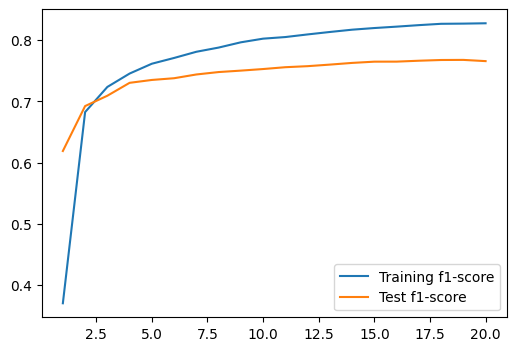

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_metrics_list)+1),train_f1_list, label='Training f1-score')
plt.plot(range(1,len(val_metrics_list)+1),val_f1_list,label='Test f1-score')
plt.legend()
plt.show()

In [24]:
#Get test data and labels through data iterator
'''Test batch- tensor of n_sentences x max_len_sentence
   Labels_batch- tensor of n_sentences x max_len_sentence
   Test sentences- list of n_sentences x sentence_length(no padding)'''
test_data_iterator = data_iterator(test_sentences, test_labels, len(test_sentences), len(test_sentences),
                                   shuffle=True, cuda=torch.cuda.is_available())
test_batch, labels_batch, test_sentences = next(test_data_iterator)


In [25]:
model_output = model(test_batch)
model_output_numpy = model_output.cpu().detach().numpy()
labels_batch_numpy = labels_batch.cpu().detach().numpy()

In [26]:
predicted_labels = np.argmax(model_output.cpu().detach().numpy(), axis=1)
print(f"Number of sentences: \n {len(test_sentences)}")
print(f"Number of predicted word labels \n {len(predicted_labels)}")

Number of sentences: 
 3453
Number of predicted word labels 
 428172


In [27]:
#Show model output on sample from test set
sample_output = model(test_batch[10].unsqueeze(0)).cpu()
sample_sentence = id_to_words(test_sentences[10])
sample_mask = (labels_batch[10] >= 0).cpu()
sample_label_predict = np.argmax(sample_output.detach().numpy(), axis=1)[sample_mask]
sample_label_true = labels_batch[10][sample_mask]
print(f"Sample sentence: {sample_sentence}")
print(f"sample_label_predict: {id_to_labels(sample_label_predict)}")
print(f"sample_label_true: {id_to_labels(sample_label_true.cpu().numpy())}")

Sample sentence: ['Yevgeny', 'Kafelnikov', 'UNK', 'Russia', 'UNK', 'beat', 'Jim', 'Courier', 'UNK', 'U.S.', 'UNK', 'UNK', 'UNK', 'UNK']
sample_label_predict: ['I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'O', 'O']
sample_label_true: ['I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'I-PER', 'I-PER', 'O', 'I-LOC', 'O', 'O', 'O', 'O']


In [28]:
#compute f1 score for test set
f1_score_seqeval = calculate_multiclass_f1_score(model_output_numpy, labels_batch_numpy)
print(f"Test set f1 score: {f1_score_seqeval}")

Test set f1 score: 0.7367508023245728


In [29]:
model_class_report = classification_report_gen(model_output_numpy, labels_batch_numpy)
print(f"model_class_report: \n{model_class_report}")

model_class_report: 
              precision    recall  f1-score   support

         LOC       0.78      0.81      0.80      1661
        MISC       0.63      0.64      0.64       702
         ORG       0.60      0.70      0.65      1655
         PER       0.84      0.80      0.82      1611

   micro avg       0.72      0.75      0.74      5629
   macro avg       0.71      0.74      0.72      5629
weighted avg       0.73      0.75      0.74      5629
